## Assignment 04

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana

### 0.1 Environment Information

In [1]:
%load_ext tensorboard

In [2]:
import torch
from pytorch_lightning import seed_everything

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

data_dir = "~/.datasets"
print("Data Dir:", data_dir)

seed = 42
seed_everything(seed)

if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
print("Set Random Seed:", seed)

Device: cuda:0
Data Dir: ~/.datasets
Device Name: GeForce GTX 1660 Ti
Set Random Seed: 42


### 1.1 Train a CNN for CIFAR10 with the best parameters


In [3]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

CIFAR10_TRANSFORMS = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
)


class CNN(LightningModule):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(CNN, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        self.loss = nn.CrossEntropyLoss()
        self.batch_size = 256
        if init_weights:
            self._initialize_weights()
            
    def set_features(self, features):
        self.features = features

    def _initialize_weights(self):
        """ from PyTorch's VGG Implementation """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-3, weight_decay=0.4)

    def train_dataloader(self):
        dataset = CIFAR10(
            data_dir, train=True, download=True, transform=CIFAR10_TRANSFORMS
        )
        loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            drop_last=True,
            num_workers=10,
            shuffle=True,
        )
        return loader

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss(y_hat, y)

        labels_hat = torch.argmax(y_hat, dim=1)
        train_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        tensorboard_logs = {"train_loss": loss.item(), "train_acc": train_acc}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        labels_hat = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        return {"val_loss": self.loss(y_hat, y), "val_acc": torch.tensor(val_acc)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "val_acc": avg_acc, "log": tensorboard_logs}

    def val_dataloader(self):
        dataset = CIFAR10(
            data_dir, train=False, download=True, transform=CIFAR10_TRANSFORMS
        )
        loader = DataLoader(
            dataset, batch_size=self.batch_size, drop_last=True, num_workers=10
        )
        return loader

    @torch.no_grad()
    def get_all_preds(self):
        all_preds = torch.tensor([]).to(device)
        labels = torch.tensor([], dtype=torch.int64).to(device)
        for x, y in self.val_dataloader():
            x, y = x.to(device), y.to(device)
            y_hat = self(x)
            all_preds = torch.cat((all_preds, y_hat), dim=0)
            labels = torch.cat((labels, y), dim=0)
        pred_labels = all_preds.argmax(dim=1)
        return pred_labels, labels


class MaxAvgPool2d(nn.Module):
    def __init__(self, **kwargs):
        super(MaxAvgPool2d, self).__init__()
        self.max_pooling = nn.MaxPool2d(**kwargs)
        self.avg_pooling = nn.AvgPool2d(**kwargs)

    def forward(self, x):
        return torch.cat([self.max_pooling(x), self.avg_pooling(x)], dim=-1)


## 1.2 Helper Functions to Construct ConvNets and Run Experiments

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


def make_layers(cfg):
    """ from PyTorch's VGG Implementation """
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == "A":
            layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        elif v == "MA":
            layers += [MaxAvgPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def run_experiment(tensorboard_graph_name, cfg, max_epochs=50, **kargs):
    model = CNN(features=make_layers(cfg), **kargs)

    if tensorboard_graph_name:
        logger = TensorBoardLogger("lightning_logs", name=tensorboard_graph_name)
    else:
        logger = False

    trainer = Trainer(
        gpus=1,
        num_nodes=1,
        deterministic=True,
        max_epochs=max_epochs,
        logger=logger, # set False to disble tensorboard logs
        progress_bar_refresh_rate=0, # disable progress bar
    )
    trainer.fit(model)

    return model


## 1.3 Find Architectures That Work Best (inspired by the VGG configurations)

We experimented with the **classifier layer** by increasing the depth and number of neurons to reduce the rate of fluctuations in the validation learning curve.

For the **features layer**, we found that the architecture that we called `Variant C: [32, 32, "M", 64, 64, "M", 128, 128, "M", 256, 256, "M"],` performs the best (considering validation accuracy and training accuracy and no smoothening on Tensorboard) given our training parameters at the end of 50 epochs. Here numbers denote the `out_channels` and `M` stands for `MaxPooling`.


In [2]:
%tensorboard --logdir lightning_logs/conv

In [6]:
model = None

In [7]:
conv_cfgs = {
    "A": [32, "M", 64, "M", 128, "M", 256, "M"],
    "B": [32, "M", 64, "M", 128, 128, "M", 256, 256, "M"],
    "C": [32, 32, "M", 64, 64, "M", 128, 128, "M", 256, 256, "M"],
    "D": [32, 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 256, 256, 256, "M"],
}

for arch, cfg in conv_cfgs.items():
    model = run_experiment(
        tensorboard_graph_name=f"conv/cfg_{arch}", cfg=cfg, max_epochs=50
    )

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 389 K 
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | MaxPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | MaxPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | features.10  | ReLU              | 0     
12 | features.11  | MaxPool2d         | 0     
13 | features.12  | Conv2d            | 295 K 
14 | features.13  | BatchNorm2d       | 512   
15 | features.14  | ReLU              | 0     
16 | features.15  | MaxPool2d        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/dhruvang/Applications/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 1 M   
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | MaxPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | MaxPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | f

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 1 M   
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | Conv2d            | 9 K   
5  | features.4   | BatchNorm2d       | 64    
6  | features.5   | ReLU              | 0     
7  | features.6   | MaxPool2d         | 0     
8  | features.7   | Conv2d            | 18 K  
9  | features.8   | BatchNorm2d       | 128   
10 | features.9   | ReLU              | 0     
11 | features.10  | Conv2d            | 36 K  
12 | features.11  | BatchNorm2d       | 128   
13 | features.12  | ReLU              | 0     
14 | features.13  | MaxPool2d         | 0     
15 | features.14  | Conv2d            | 73 K  
16 | features.15  | BatchNorm2d      

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 1 M   
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | Conv2d            | 9 K   
5  | features.4   | BatchNorm2d       | 64    
6  | features.5   | ReLU              | 0     
7  | features.6   | Conv2d            | 9 K   
8  | features.7   | BatchNorm2d       | 64    
9  | features.8   | ReLU              | 0     
10 | features.9   | MaxPool2d         | 0     
11 | features.10  | Conv2d            | 18 K  
12 | features.11  | BatchNorm2d       | 128   
13 | features.12  | ReLU              | 0     
14 | features.13  | Conv2d            | 36 K  
15 | features.14  | BatchNorm2d       | 128   
16 | features.15  | ReLU             

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 2. Comparing different pooling layers: [Average, Max, Average+Max]

We found that `Max Pooling` performs the best.

In [3]:
%tensorboard --logdir lightning_logs/pooling

In [ ]:
pooling_cfgs = {
    "A_M+A": [32, "MA", 64, "MA", 128, "MA", 256, "MA"],
    "A_A": [32, "A", 64, "A", 128, "A", 256, "A"],
    "A_M": [32, "M", 64, "M", 128, "M", 256, "M"],
}

for arch, cfg in pooling_cfgs.items():
    model = run_experiment(
        tensorboard_graph_name=f"pooling/cfg_{arch}", cfg=cfg, max_epochs=50
    )

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type              | Params
----------------------------------------------------------
0  | features                | Sequential        | 389 K 
1  | features.0              | Conv2d            | 896   
2  | features.1              | BatchNorm2d       | 64    
3  | features.2              | ReLU              | 0     
4  | features.3              | MaxAvgPool2d      | 0     
5  | features.3.max_pooling  | MaxPool2d         | 0     
6  | features.3.avg_pooling  | AvgPool2d         | 0     
7  | features.4              | Conv2d            | 18 K  
8  | features.5              | BatchNorm2d       | 128   
9  | features.6              | ReLU              | 0     
10 | features.7              | MaxAvgPool2d      | 0     
11 | features.7.max_pooling  | MaxPool2d         | 0     
12 | features.7.avg_pooling  | AvgPool2d         | 0     
13 | features

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 389 K 
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | AvgPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | AvgPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | features.10  | ReLU              | 0     
12 | features.11  | AvgPool2d         | 0     
13 | features.12  | Conv2d            | 295 K 
14 | features.13  | BatchNorm2d       | 512   
15 | features.14  | ReLU              | 0     
16 | features.15  | AvgPool2d        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 389 K 
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | MaxPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | MaxPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | features.10  | ReLU              | 0     
12 | features.11  | MaxPool2d         | 0     
13 | features.12  | Conv2d            | 295 K 
14 | features.13  | BatchNorm2d       | 512   
15 | features.14  | ReLU              | 0     
16 | features.15  | MaxPool2d        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 3. Visualize Kernel of Each Convolution Filter

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils


def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):

    # Un-Normalize
    tensor = tensor / 2 + 0.5

    n, c, w, h = tensor.shape
    if allkernels:
        tensor = tensor.view(n * c, -1, w, h)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


In [6]:
model = run_experiment(
        tensorboard_graph_name=None, cfg=[32, "M", 64, "M", 128, "M", 256, "M"], max_epochs=20
    )

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 389 K 
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | MaxPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | MaxPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | features.10  | ReLU              | 0     
12 | features.11  | MaxPool2d         | 0     
13 | features.12  | Conv2d            | 295 K 
14 | features.13  | BatchNorm2d       | 512   
15 | features.14  | ReLU              | 0     
16 | features.15  | MaxPool2d        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/dhruvang/Applications/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)



Conv2d in Layer 0
------------
torch.Size([32, 3, 3, 3])

Conv2d in Layer 4
------------
torch.Size([64, 32, 3, 3])

Conv2d in Layer 8
------------
torch.Size([128, 64, 3, 3])

Conv2d in Layer 12
------------
torch.Size([256, 128, 3, 3])


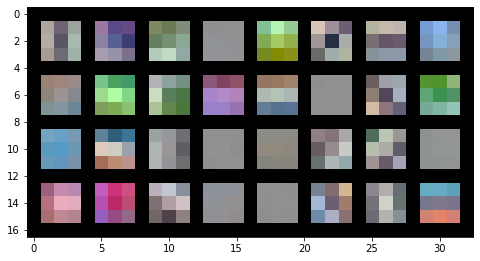

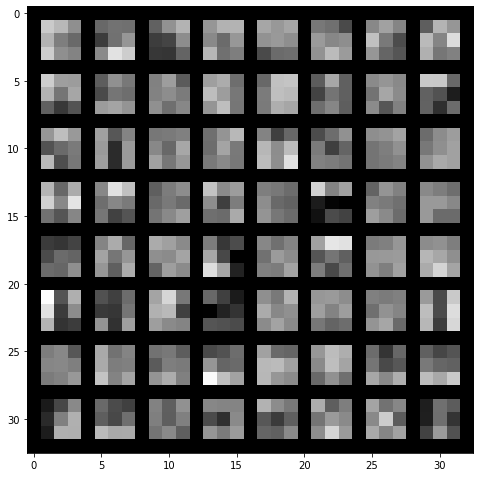

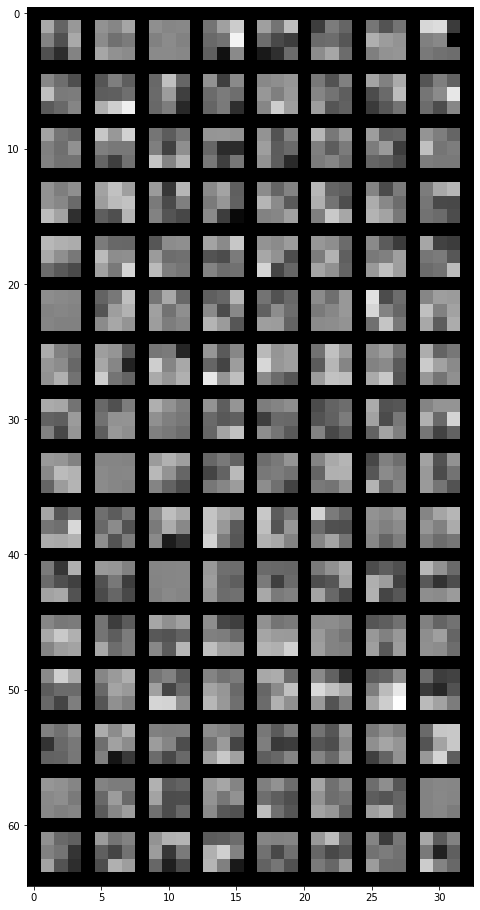

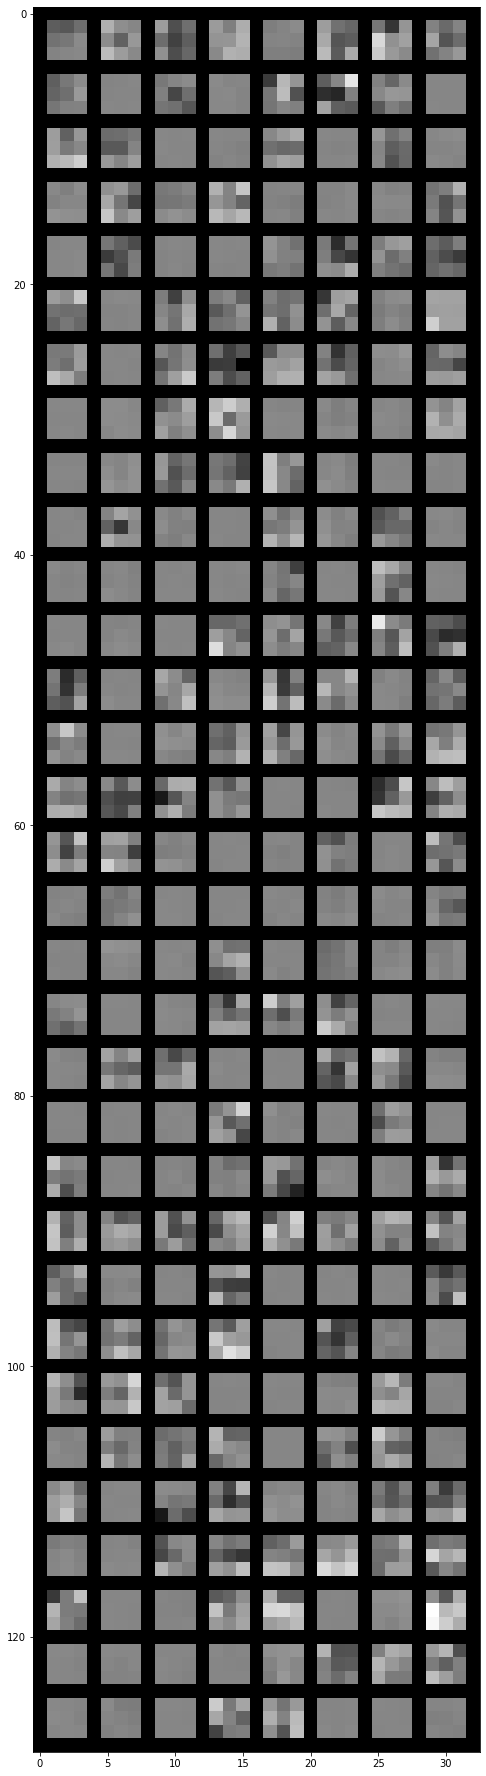

In [7]:
for i, layer in enumerate(model.features):
    if type(layer) is nn.Conv2d:
        print(f"\nConv2d in Layer {i}\n------------")
        kernel = layer.weight.data.cpu()
        print(kernel.shape)
        vistensor(kernel, ch=0, allkernels=False)

### 4. Visualize Activation

In [8]:

def vis_activation(tensor, nrow=8, padding=1):
    
    # Un-Normalize
    tensor = tensor / 2 + 0.5

    n, c, w, h = tensor.shape
    tensor = tensor.view(n * c, -1, w, h)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=False, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)), interpolation="nearest")


In [9]:
model = run_experiment(
        tensorboard_graph_name=None, cfg=[32, "M", 64, "M", 128, "M", 256, "M"], max_epochs=20
    )

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 389 K 
1  | features.0   | Conv2d            | 896   
2  | features.1   | BatchNorm2d       | 64    
3  | features.2   | ReLU              | 0     
4  | features.3   | MaxPool2d         | 0     
5  | features.4   | Conv2d            | 18 K  
6  | features.5   | BatchNorm2d       | 128   
7  | features.6   | ReLU              | 0     
8  | features.7   | MaxPool2d         | 0     
9  | features.8   | Conv2d            | 73 K  
10 | features.9   | BatchNorm2d       | 256   
11 | features.10  | ReLU              | 0     
12 | features.11  | MaxPool2d         | 0     
13 | features.12  | Conv2d            | 295 K 
14 | features.13  | BatchNorm2d       | 512   
15 | features.14  | ReLU              | 0     
16 | features.15  | MaxPool2d        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
from functools import partial


def vis_relu(name, mod, inp, out):
    print("Shape", out.shape)
    vis_activation(out.detach().cpu())


prev = None

for name, m in model.named_modules():
    if type(m) == nn.ReLU and prev == nn.BatchNorm2d:
        m.register_forward_hook(partial(vis_relu, name))

    prev = type(m)

Files already downloaded and verified
Shape torch.Size([1, 32, 32, 32])
Shape torch.Size([1, 64, 16, 16])
Shape torch.Size([1, 128, 8, 8])
Shape torch.Size([1, 256, 4, 4])


tensor([[-0.4175, -0.4971, -1.8140,  0.5991, -1.4435, -0.6260, -1.7792, -0.7363,
         -0.5750, -0.0058]], device='cuda:0', grad_fn=<AddmmBackward>)

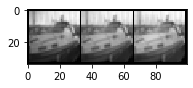

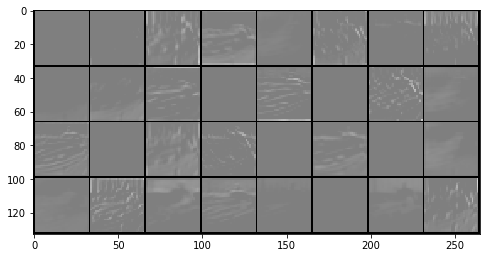

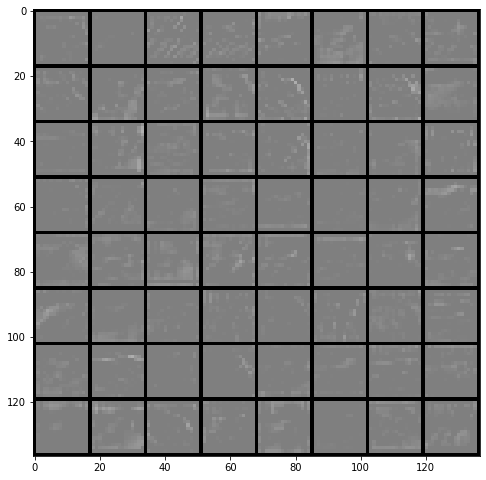

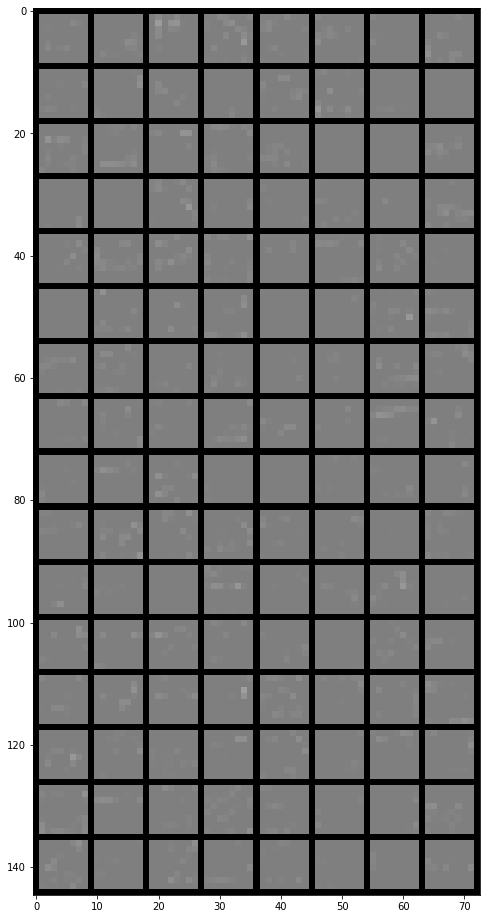

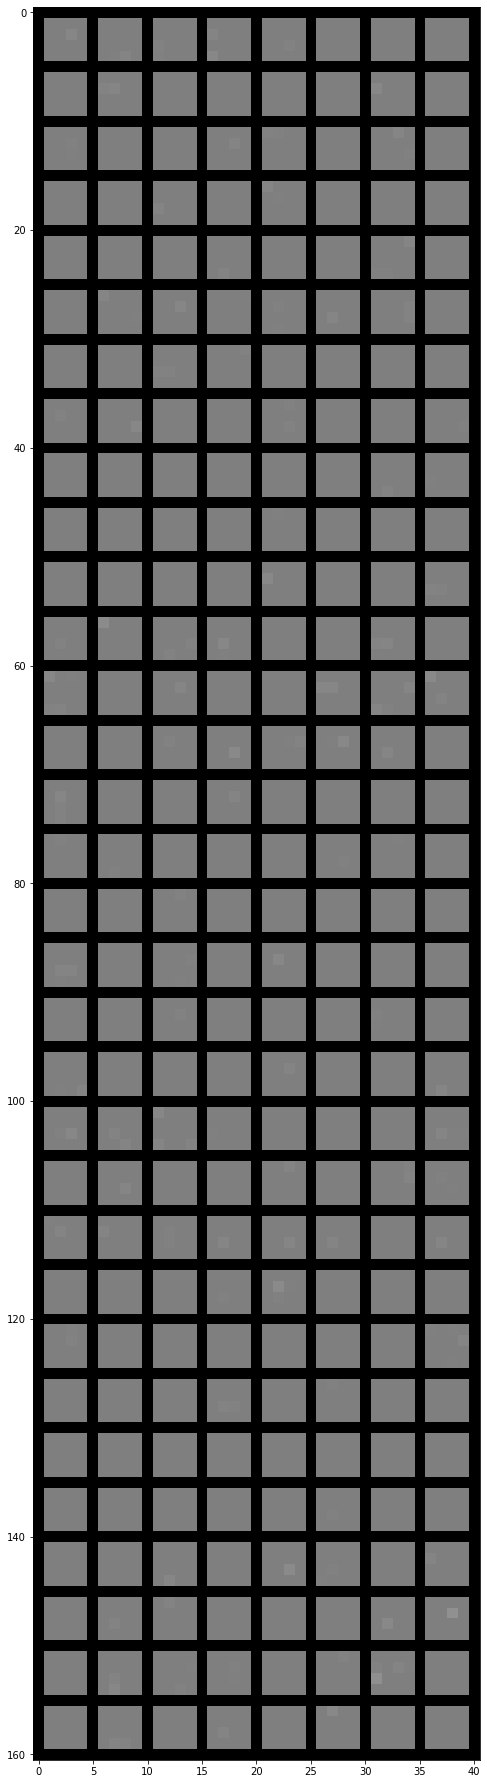

In [11]:
val_data_iter = iter(model.val_dataloader())
images, labels = val_data_iter.next()
batch_single_image = images[2:3].clone().detach().to(device)

vis_activation(batch_single_image.cpu())

model(batch_single_image)

### 5. Load Convolution Layer's Weights into Fully Connected Layer

In [12]:
features_conv_1x1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=1, padding=0),################## Original Conv Layer
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
)

features_fc = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Linear(32, 32), ########################################### LINEAR
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
)

# print('\n===\nfeatures_fc:\n===')
# for k, v in features_fc.state_dict().items():
#     print("Layer {}".format(k))
#     print(v.shape)


def run_features_experiment(features, max_epochs=50, **kargs):
    model = CNN(features=features, **kargs)
    trainer = Trainer(
        gpus=1,
        num_nodes=1,
        deterministic=True,
        max_epochs=max_epochs,
        logger=False,
        progress_bar_refresh_rate=0,
    )
    trainer.fit(model)
    return model

In [13]:
model = run_features_experiment(features_conv_1x1, max_epochs = 1)

preds_features_conv_1x1, _ = model.get_all_preds()

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 75 K  
1  | features.0   | Conv2d            | 896   
2  | features.1   | ReLU              | 0     
3  | features.2   | Conv2d            | 1 K   
4  | features.3   | ReLU              | 0     
5  | features.4   | Conv2d            | 73 K  
6  | features.5   | ReLU              | 0     
7  | avgpool      | AdaptiveAvgPool2d | 0     
8  | classifier   | Sequential        | 13 M  
9  | classifier.0 | Linear            | 12 M  
10 | classifier.1 | ReLU              | 0     
11 | classifier.2 | Dropout           | 0     
12 | classifier.3 | Linear            | 1 M   
13 | classifier.4 | ReLU              | 0     
14 | classifier.5 | Dropout           | 0     
15 | classifier.6 | Linear            | 10 K  
16 | loss         | CrossEntropyLoss 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


> We are able to load our `state_dict` from the conv model into the FC model. From the `get_all_preds()` we can see that this model's neurons are able to fire without any issues

In [14]:
from collections import OrderedDict

new_state_dict = OrderedDict()

for k, v in features_conv_1x1.state_dict().items():
    new_state_dict[k] = torch.squeeze(v.clone().detach()).to(device)
    
features_fc.load_state_dict(new_state_dict)

features_fc = features_fc.to(device)

model.set_features(features_fc)
preds_features_fc, tgt = model.get_all_preds()

model.set_features(features_conv_1x1)
pred_features_conv_1x1, tgt = model.get_all_preds()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
features_fc.state_dict()['2.weight']

tensor([[-0.1306,  0.0030,  0.1695,  ...,  0.2144,  0.2032,  0.0785],
        [ 0.1617,  0.1247, -0.0907,  ...,  0.0280,  0.3434, -0.0691],
        [ 0.0648, -0.0791,  0.0908,  ..., -0.1090,  0.0579, -0.1092],
        ...,
        [ 0.0592,  0.3555,  0.1133,  ...,  0.0289, -0.1226, -0.0317],
        [ 0.1917,  0.0768, -0.2183,  ...,  0.1390,  0.2655,  0.1896],
        [-0.2218, -0.2047, -0.0666,  ..., -0.1310, -0.0131, -0.1217]],
       device='cuda:0')

In [16]:
features_conv_1x1.state_dict()['2.weight'].reshape(32, 32)

tensor([[-0.1306,  0.0030,  0.1695,  ...,  0.2144,  0.2032,  0.0785],
        [ 0.1617,  0.1247, -0.0907,  ...,  0.0280,  0.3434, -0.0691],
        [ 0.0648, -0.0791,  0.0908,  ..., -0.1090,  0.0579, -0.1092],
        ...,
        [ 0.0592,  0.3555,  0.1133,  ...,  0.0289, -0.1226, -0.0317],
        [ 0.1917,  0.0768, -0.2183,  ...,  0.1390,  0.2655,  0.1896],
        [-0.2218, -0.2047, -0.0666,  ..., -0.1310, -0.0131, -0.1217]],
       device='cuda:0')

In [17]:
torch.sum(preds_features_conv_1x1 == tgt) / (len(tgt) * 1.0)

tensor(0.4844, device='cuda:0')

In [18]:
torch.sum(preds_features_fc == tgt) / (len(tgt) * 1.0)

tensor(0.1237, device='cuda:0')

```
We see that we are able to load the convolution layer weights into the FC layer. Also we verify the neurons don't have any wiring issues by making predictions on both networks and getting different results.
```